# Milky-Way analog aggregate model calculation

In this notebook we make use Galaxy Builder classifications, alongside the custom code developed for aggregation of models, to calculate and vizualise aggregate models for the Milky-Way analogue subject set.

In [1]:
print('Defining magic commands ✨')
%load_ext autoreload
%autoreload 2
%matplotlib inline

Defining magic commands ✨


In [2]:
print('Importing needed modules...')
import os
import json
import numpy as np
import pandas as pd
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import lib.galaxy_utilities as gu
import gzbuilderaggregation
import gzbuilderaggregation.parse_annotation as pa
import gzbuilderaggregation.average_shape_helpers as ash
from descartes import PolygonPatch
from IPython.display import display, Markdown
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

Importing needed modules...


Define which subject to work on

In [3]:
subject_id = 30055870

The MaNGA RGB-composite for this galaxy looks like (or a skyserver link if no Manga ID):

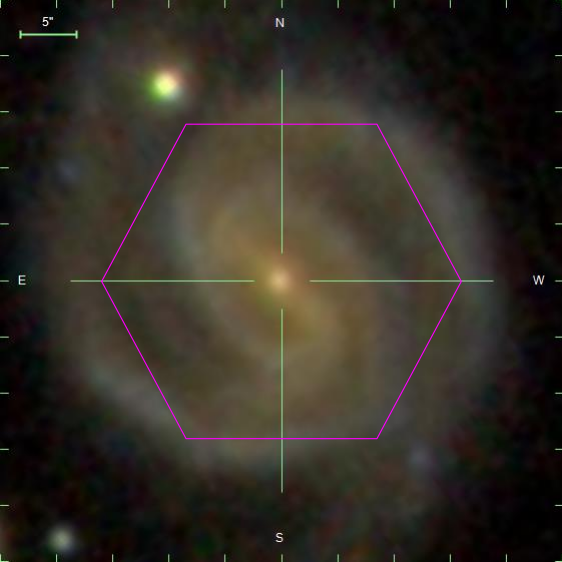

In [4]:
meta = gu.subjects.query(
    'subject_id == {}'.format(subject_id)
)['metadata'].apply(json.loads).iloc[0]
if meta.get('Plate IFU', False):
    marvin_url =(
        'https://data.sdss.org/'
        'sas/dr15/manga/spectro/redux/v2_4_3/'
        '{0}/stack/images/{1}.png'
    ).format(*meta['Plate IFU'].split('-'))
    im = Image.open(BytesIO(requests.get(marvin_url).content))
    display(im)
    im.save('plots/example-manga-galaxy.png')
else:
    
    display(Markdown(
        'No MaNGA ID - {}'.format(
            meta['Url to view'].replace('](+tab+', '](')
        )
    ))

We'll need some metadata to properly plot results

In [5]:
gal, angle = gu.get_galaxy_and_angle(subject_id)
pic_array = gu.get_image(subject_id)
psf = gu.get_psf(subject_id)
diff_data = gu.get_diff_data(subject_id)
pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
galaxy_data = np.array(diff_data['imageData'])[::-1]
size_diff = diff_data['width'] / diff_data['imageWidth']

Grab the classifications corresponding to the galaxy

In [6]:
cls = gu.classifications.query('subject_ids == {}'.format(subject_id))

What do the drawn components look like?

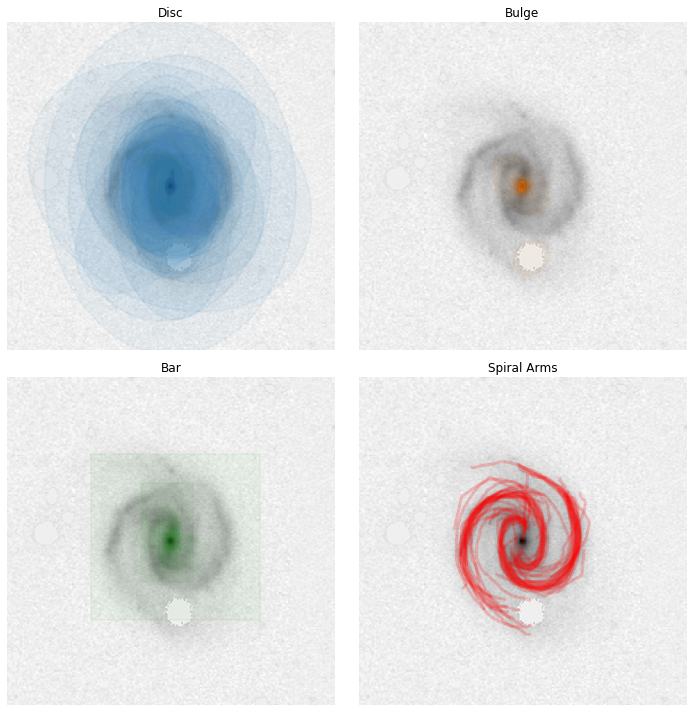

In [7]:
annotations = cls['annotations'].apply(json.loads).apply(pa.parse_annotation, size_diff=size_diff)
plt.figure(figsize=(10, 10))
def show_im():
  plt.imshow(
      pic_array, origin='lower', cmap='gray_r',
      extent=(0, diff_data['width'], 0, diff_data['height'])
  )
  plt.axis('off')
plt.subplot(221)
show_im()
for _, disk in annotations.apply(lambda a: a['disk']).dropna().iteritems():
    p = PolygonPatch(ash.make_ellipse(disk), fc='C0', ec='C0', lw=2, alpha=0.05)
    plt.gca().add_patch(p)
plt.title('Disc')
plt.subplot(222)
show_im()
for _, bulge in annotations.apply(lambda a: a['bulge']).dropna().iteritems():
    p = PolygonPatch(ash.make_ellipse(bulge), fc='C1', ec='C1', lw=2, alpha=0.05)
    plt.gca().add_patch(p)
plt.title('Bulge')
plt.subplot(223)
show_im()
for _, bar in annotations.apply(lambda a: a['bar']).dropna().iteritems():
    p = PolygonPatch(ash.make_box(bar), fc='C2', ec='C2', lw=2, alpha=0.05)
    plt.gca().add_patch(p)
plt.title('Bar')
plt.subplot(224)
show_im()
for _, a in annotations.items():
    for arm in a['spiral']:
        plt.plot(*arm[0].T, alpha=0.2, c='r', lw=3)
plt.title('Spiral Arms')
plt.tight_layout()
plt.savefig('plots/example-classifications.pdf', bbox_inches='tight');

Make use of the `gzbuilderaggregation` package to calculate aggregate models (which uses `gzbuilderspirals` to obtain logarithmic spiral fits)

In [8]:
agg_model, masks, arms = gzbuilderaggregation.make_model(cls, gal, angle)

And we're done! What does the aggregate model look like?

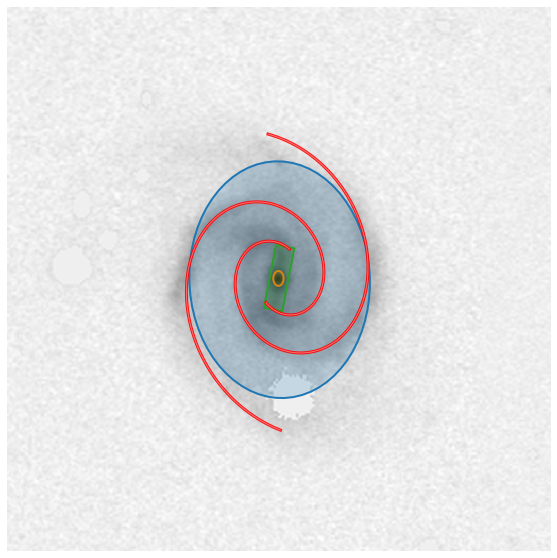

In [9]:
disk = ash.make_ellipse(agg_model['disk'])
bulge = ash.make_ellipse(agg_model['bulge'])
bar = ash.make_box(agg_model['bar'])

plt.figure(figsize=(10, 10))
plt.imshow(pic_array, origin='lower', cmap='gray_r')
for i, geom in enumerate((disk, bulge, bar)):
    if geom is not None:
        p = PolygonPatch(geom, fc='none', ec='C{}'.format(i), zorder=2, lw=2)
        p2 = PolygonPatch(geom, fc='C{}'.format(i), ec='none', alpha=0.2, zorder=2, lw=2)
        plt.gca().add_patch(p)
        plt.gca().add_patch(p2)

for i, arm in enumerate(arms):
    plt.plot(*arm.reprojected_log_spiral.T, c='r', 
             linewidth=3, alpha=0.9)
    plt.plot(*arm.reprojected_log_spiral.T, c='w', linewidth=1, alpha=0.4)
plt.axis('off')
plt.savefig('plots/example-aggregate-model.pdf', bbox_inches='tight');

# Optimization

The next step is to fine-tune this aggregate model such that it best matches the underlying galaxy. This can be achieved using `gzbuilderfitting`.